## Import Modules

In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import math
import time
import warnings
warnings.filterwarnings('ignore')

## Define specialized variables

In [2]:
match_week_stage = math.floor((3/4)*34)
print(match_week_stage)

25


## Obtain League and shots data from Statsbomb

In [3]:
competitions = sb.competitions()

In [4]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [5]:
Bundesliga = sb.matches(competition_id=9, season_id=27)
Bundesliga.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3890561,2016-05-14,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hoffenheim,Schalke 04,1,4,available,...,None,34,Regular Season,PreZero Arena,Felix Brych,Julian Nagelsmann,André Breitenreiter,1.1.0,2,2
1,3890505,2016-04-02,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Bayern Munich,Eintracht Frankfurt,1,0,available,...,None,28,Regular Season,Allianz Arena,Florian Meyer,Josep Guardiola i Sala,Niko Kovač,1.1.0,2,2
2,3890511,2016-04-08,20:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,Hannover 96,2,2,available,...,None,29,Regular Season,Olympiastadion Berlin,Benjamin Brand,Pál Dárdai,Daniel Stendel,1.1.0,2,2
3,3890515,2016-04-09,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hamburger SV,Darmstadt 98,1,2,available,...,None,29,Regular Season,Volksparkstadion,Peter Sippel,Bruno Labbadia,Dirk Schuster,1.1.0,2,2
4,3890411,2015-12-20,16:30:00.000,Germany - 1. Bundesliga,2015/2016,Hertha Berlin,FSV Mainz 05,2,0,available,...,None,17,Regular Season,Olympiastadion Berlin,Peter Sippel,Pál Dárdai,Martin Schmidt,1.1.0,2,2


### Get idea of column names for league matches

In [6]:
Bundesliga.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [7]:
print(pd.unique(Bundesliga['home_team']))

['Hoffenheim' 'Bayern Munich' 'Hertha Berlin' 'Hamburger SV'
 'Borussia Dortmund' 'Wolfsburg' 'Schalke 04' 'FSV Mainz 05' 'Augsburg'
 'Bayer Leverkusen' 'Darmstadt 98' 'Werder Bremen' 'FC Köln'
 'Eintracht Frankfurt' 'VfB Stuttgart' 'Borussia Mönchengladbach'
 'Ingolstadt' 'Hannover 96']


In [8]:
example = sb.events(match_id=3754037)
#example.columns
pd.unique(example['shot_aerial_won'])

array([nan, True], dtype=object)

In [9]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome', 'under_pressure']

In [10]:
Bundesliga_shots_df = pd.DataFrame(columns=relevant_attributes)

In [11]:
start = time.time()
for match in Bundesliga[Bundesliga['match_week']<=match_week_stage]['match_id']:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    Bundesliga_shots_df = pd.concat([Bundesliga_shots_df, relevant_match_df], ignore_index=True)

Bundesliga_shots_df['shot_outcome'] = Bundesliga_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

Bundesliga_shots_df['distance'] = Bundesliga_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
Bundesliga_shots_df['shot_angle'] = Bundesliga_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
Bundesliga_shots_df

script run time: 3.80561603307724 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle
0,15,7,Hertha Berlin,0.051886,John Anthony Brooks,Left Center Back,"[110.3, 43.5]",Head,"[120.0, 43.6, 4.5]",NaN,Normal,Open Play,Shot,0,True,10.312129,0.346286
1,23,32,Hertha Berlin,0.118663,Vedad Ibišević,Center Forward,"[109.7, 34.5]",Right Foot,"[120.0, 35.4, 1.0]",True,Volley,Open Play,Shot,0,True,11.676472,0.490461
2,33,17,Hertha Berlin,0.081732,Vladimír Darida,Center Attacking Midfield,"[99.5, 35.8]",Left Foot,"[120.0, 36.7, 0.2]",NaN,Normal,Open Play,Shot,1,NaN,20.925821,0.202082
3,41,51,Hertha Berlin,0.046305,John Anthony Brooks,Left Center Back,"[110.6, 44.4]",Head,"[118.7, 40.3, 1.8]",NaN,Normal,Open Play,Shot,0,True,10.378825,0.437791
4,41,52,Hertha Berlin,0.631979,Sebastian Langkamp,Right Center Back,"[116.7, 39.6]",Other,"[117.6, 39.9, 1.0]",NaN,Normal,Open Play,Shot,0,NaN,3.324154,0.120624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,72,14,Bayern Munich,0.248334,Thomas Müller,Right Center Midfield,"[113.6, 30.4]",Left Foot,"[120.0, 38.9, 0.2]",NaN,Normal,Open Play,Shot,1,NaN,11.537764,0.982794
5824,77,17,Bayern Munich,0.028587,David Olatukunbo Alaba,Left Back,"[99.2, 25.5]",Left Foot,"[117.7, 36.8, 2.2]",NaN,Normal,Open Play,Shot,0,NaN,25.355276,0.608787
5825,83,16,Bayern Munich,0.007272,Douglas Costa de Souza,Right Midfield,"[106.5, 64.6]",Left Foot,"[120.0, 37.3, 3.6]",NaN,Normal,Open Play,Shot,0,NaN,28.060827,1.068890
5826,86,15,Bayern Munich,0.025284,Douglas Costa de Souza,Right Midfield,"[100.7, 57.0]",Left Foot,"[120.0, 37.0, 0.7]",NaN,Normal,Open Play,Shot,1,True,25.719448,0.722122


## Describing the Data

In [12]:
Bundesliga_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,5828.000000,5828.000000,5828.000000,5828.000000
mean,0.105527,0.103809,18.861824,0.480680
std,0.150130,0.305039,8.522000,0.324562
min,0.000180,0.000000,1.220656,0.000000
25%,0.027431,0.000000,11.900420,0.211093
50%,0.054679,0.000000,17.951181,0.439943
75%,0.108521,0.000000,25.205555,0.705796
max,0.973276,1.000000,84.986881,1.568199


In [13]:
Bundesliga_shots_df = Bundesliga_shots_df[Bundesliga_shots_df.shot_type != 'Corner']

In [14]:
Bundesliga_shots_df['shot_outcome'].value_counts()

shot_outcome
0    5217
1     605
Name: count, dtype: int64

In [15]:
Bundesliga_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg', 'xg_overperformance'])
for team in pd.unique(Bundesliga_shots_df['team']):
    shot_sum = Bundesliga_shots_df['team'].value_counts()[team]
    goal_sum = sum(Bundesliga_shots_df[Bundesliga_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(Bundesliga_shots_df[Bundesliga_shots_df['team']==team]['shot_statsbomb_xg'])
    xg_overperformance = goal_sum - statsbomb_xg_sum
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum, 'xg_overperformance': xg_overperformance})
    Bundesliga_team_summary_df.loc[len(Bundesliga_team_summary_df)]=new_row
Bundesliga_team_summary_df = Bundesliga_team_summary_df.sort_values(by=['goals'], ascending=False)
totals_row = pd.Series({'team': 'Totals',
                        'shots': sum(Bundesliga_team_summary_df['shots']),
                        'goals': sum(Bundesliga_team_summary_df['goals']),
                        'statsbomb_xg': sum(Bundesliga_team_summary_df['statsbomb_xg']),
                        'xg_overperformance': sum(Bundesliga_team_summary_df['xg_overperformance'])})
Bundesliga_team_summary_df.loc[len(Bundesliga_team_summary_df)]=totals_row

Bundesliga_team_summary_df

,team,shots,goals,statsbomb_xg,xg_overperformance
10,Bayern Munich,503,58,62.692995,-4.692995
4,Borussia Dortmund,376,57,57.173691,-0.173691
17,Borussia Mönchengladbach,321,48,35.289549,12.710451
8,VfB Stuttgart,394,38,44.898505,-6.898505
6,Wolfsburg,371,37,37.096424,-0.096424
12,Werder Bremen,327,35,35.317857,-0.317857
9,Schalke 04,376,35,33.054793,1.945207
1,FSV Mainz 05,271,34,30.523465,3.476535
16,Bayer Leverkusen,353,32,34.915724,-2.915724
0,Hertha Berlin,233,32,27.391159,4.608841


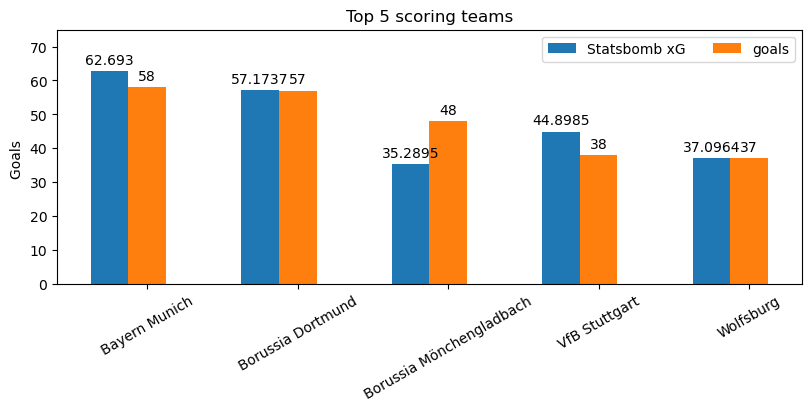

In [16]:
teams = Bundesliga_team_summary_df['team'][0:5]
team_goals = {
    'Statsbomb xG': Bundesliga_team_summary_df['statsbomb_xg'][0:5].round(),
    'goals': Bundesliga_team_summary_df['goals'][0:5].round(),
}

x = np.arange(len(teams))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))

for attribute, measurement in team_goals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Goals ')
ax.set_title('Top 5 scoring teams')
ax.set_xticks(x + width, teams)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 75)
ax.tick_params(axis='x', rotation=30)
plt.show()

In [17]:
Bundesliga_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [18]:
cap_x_df, y_df = pd.concat([Bundesliga_shots_df.iloc[:,:-4], Bundesliga_shots_df.iloc[:,-3:]], axis=1),Bundesliga_shots_df.iloc[:,-4].to_frame()

In [19]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [20]:
target_attr = 'shot_outcome'

In [21]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [22]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'under_pressure']

In [23]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [24]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=False)),
               ('target_encoder', TargetEncoder(target_type='auto', random_state=42)),
               #("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [25]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [26]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.figure()
    df = pd.DataFrame({'model1':model1,'model2':model2,'outcome':outcome})
    no_goal = df[df['outcome']==0]
    plt.scatter(no_goal['model1'],no_goal['model2'], label='no goal', color='blue', alpha=0.6)
    goal = df[df['outcome']==1]
    plt.scatter(goal['model1'],goal['model2'], label='goal', color='orange', alpha=1)
    #plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend()
    z = np.polyfit(model1, model2,1)
    #z = np.polyfit(df['model1'], df['model2'],1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    #plt.plot(df['model1'], p(df['model1']),"r--")
    print(model1_name)
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

## Train our estimators

LogisticRegression
y=0.97x+0.00
$R^2$= 0.38494406294341055
SGDClassifier
y=0.87x+0.02
$R^2$= 0.3447222969430451
RandomForestClassifier
y=0.74x+0.02
$R^2$= 0.5418921044316225
GradientBoostingClassifier
y=0.83x+0.01
$R^2$= 0.6168088655339554
DecisionTreeClassifier
y=0.21x+0.09
$R^2$= 0.16203534267436737


,shots,goals,statsbomb_xg,LogisticRegression,SGDClassifier,RandomForestClassifier,GradientBoostingClassifier,DecisionTreeClassifier
0,4657,484,488.522584,483.913902,448.975903,508.14,545.271232,437.0


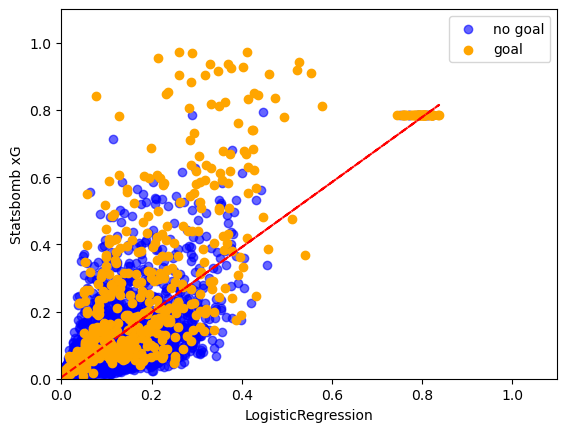

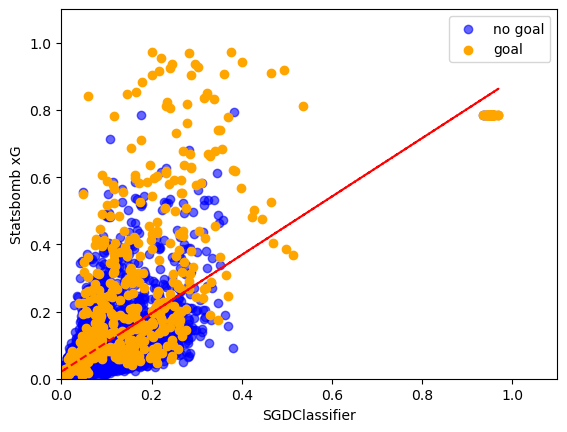

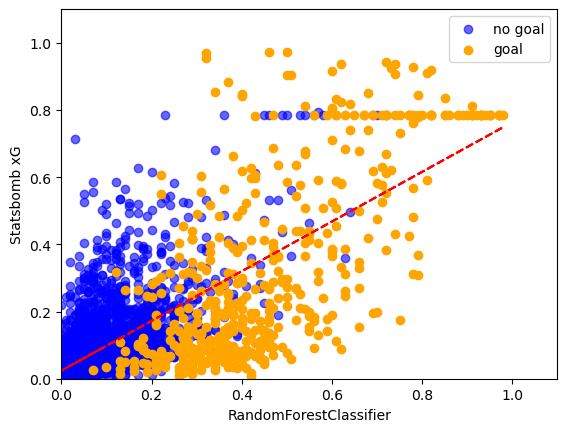

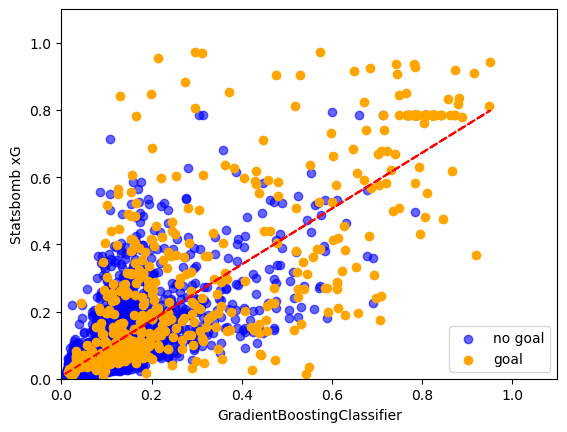

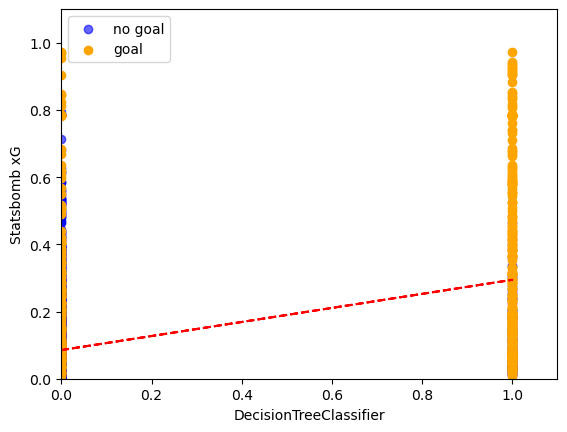

In [27]:
estimator_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 
                  'GradientBoostingClassifier', 'DecisionTreeClassifier']

estimator_list = [LogisticRegression(), SGDClassifier(loss='log_loss'), 
                  RandomForestClassifier(criterion='log_loss'), GradientBoostingClassifier(loss='log_loss'),
                 DecisionTreeClassifier(criterion='log_loss')]
trained_estimator_dict = {}
#model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg']
model_summary = {}
model_summary['shots'] = [len(train_y_df[target_attr])]
model_summary['goals'] = [train_y_df[target_attr].value_counts()[1]]
model_summary['statsbomb_xg'] = [sum(train_cap_x_df['shot_statsbomb_xg'])]
for estimator_name, estimator in zip(estimator_names, estimator_list):
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    trained_estimator_dict[estimator_name] = composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())
    predictions = trained_estimator_dict[estimator_name].predict_proba(train_cap_x_df)[:,1]
    SBModel = train_cap_x_df['shot_statsbomb_xg']
    shot_outcome = train_y_df[target_attr]
    model_summary[estimator_name] = [sum(predictions)]
    plot_comparison(predictions, estimator_name, SBModel, 'Statsbomb xG', shot_outcome)
#print(pd.DataFrame(model_summary))
pd.DataFrame.from_dict(model_summary)

## Select best model and examine permutation importance

In [28]:
best_model_name = 'GradientBoostingClassifier'
best_model = trained_estimator_dict[best_model_name]

In [29]:
feature_importances = permutation_importance(
    best_model, train_cap_x_df, train_y_df.values.ravel())

In [30]:
mean_feature_importances = pd.Series(feature_importances.importances_mean, index=train_cap_x_df.columns)
mean_feature_importances.sort_values(ascending=False)

distance             0.033412
shot_type            0.011810
shot_angle           0.004982
position             0.003006
shot_body_part       0.002706
under_pressure       0.002147
shot_first_time      0.001160
shot_technique       0.000730
minute               0.000387
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
location             0.000000
shot_end_location    0.000000
type                 0.000000
dtype: float64

In [31]:
std_feature_importances = pd.Series(feature_importances.importances_std, index=train_cap_x_df.columns)
std_feature_importances

minute               0.000210
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
position             0.000192
location             0.000000
shot_body_part       0.000442
shot_end_location    0.000000
shot_first_time      0.000105
shot_technique       0.000172
shot_type            0.001128
type                 0.000000
under_pressure       0.000543
distance             0.001726
shot_angle           0.000583
dtype: float64

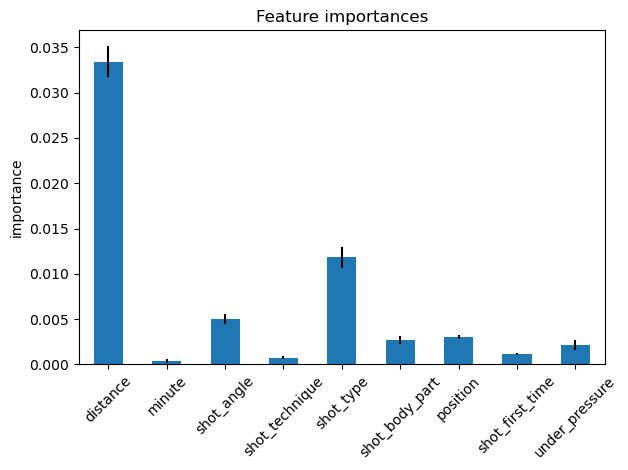

In [32]:
fig, ax = plt.subplots()
#mean_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']].plot.bar(
#    yerr=std_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']], ax=ax)
mean_feature_importances[numerical_attrs+nominal_attrs].plot.bar(
    yerr=std_feature_importances[numerical_attrs+nominal_attrs], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("importance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Evaluate on Test Set

GradientBoostingClassifier
y=0.90x+0.00
$R^2$= 0.6242061101050911


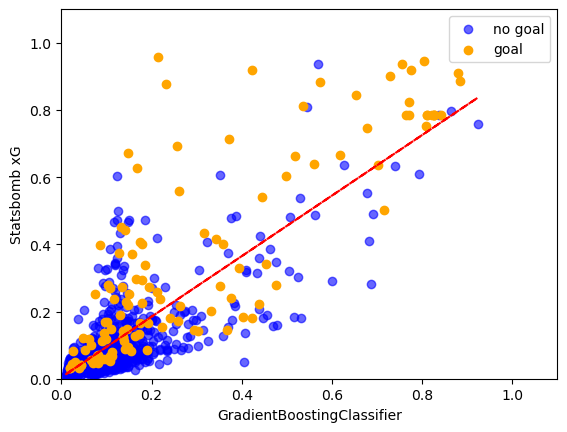

In [33]:
test_predictions = best_model.predict_proba(test_cap_x_df)[:,1]
test_SBModel = test_cap_x_df['shot_statsbomb_xg']
test_shot_outcome = test_y_df[target_attr]
plot_comparison(test_predictions, best_model_name, test_SBModel, 'Statsbomb xG', test_shot_outcome)

## Observe behavior on totality of test set

In [34]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'best_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
best_model_xg = sum(test_predictions)
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'best_model_xg': best_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,best_model_xg
0,1165.0,121.0,126.489679,134.59437


## Examine on Week to Week Basis

### Get matches for a particular team

In [35]:
def get_games_for_team(team):
    df = Bundesliga[(Bundesliga['home_team']==team)|(Bundesliga['away_team']==team)]
    df = df.sort_values(by='match_week')
    return df

In [36]:
Dortmund_games = get_games_for_team('Borussia Dortmund')
Dortmund_games

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
303,3890261,2015-08-15,18:30:00.000,Germany - 1. Bundesliga,2015/2016,Borussia Dortmund,Borussia Mönchengladbach,4,0,available,...,None,1,Regular Season,Signal-Iduna-Park,Tobias Stieler,Thomas Tuchel,Lucien Favre,1.1.0,2,2
291,3890275,2015-08-23,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Ingolstadt,Borussia Dortmund,0,4,available,...,None,2,Regular Season,Audi-Sportpark,Christian Dingert,Ralph Hasenhüttl,Thomas Tuchel,1.1.0,2,2
283,3890284,2015-08-30,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Borussia Dortmund,Hertha Berlin,3,1,available,...,None,3,Regular Season,Signal-Iduna-Park,Guido Winkmann,Thomas Tuchel,Pál Dárdai,1.1.0,2,2
276,3890292,2015-09-12,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Hannover 96,Borussia Dortmund,2,4,available,...,None,4,Regular Season,Heinz von Heiden-Arena,Daniel Siebert,Michael Frontzeck,Thomas Tuchel,1.1.0,2,2
267,3890301,2015-09-20,17:30:00.000,Germany - 1. Bundesliga,2015/2016,Borussia Dortmund,Bayer Leverkusen,3,0,available,...,None,5,Regular Season,Signal-Iduna-Park,Deniz Aytekin,Thomas Tuchel,Roger Schmidt,1.1.0,2,2
258,3890310,2015-09-23,20:00:00.000,Germany - 1. Bundesliga,2015/2016,Hoffenheim,Borussia Dortmund,1,1,available,...,None,6,Regular Season,PreZero Arena,Tobias Welz,Markus Gisdol,Thomas Tuchel,1.1.0,2,2
247,3890321,2015-09-27,17:30:00.000,Germany - 1. Bundesliga,2015/2016,Borussia Dortmund,Darmstadt 98,2,2,available,...,None,7,Regular Season,Signal-Iduna-Park,Robert Hartmann,Thomas Tuchel,Dirk Schuster,1.1.0,2,2
239,3890329,2015-10-04,17:30:00.000,Germany - 1. Bundesliga,2015/2016,Bayern Munich,Borussia Dortmund,5,1,available,...,None,8,Regular Season,Allianz Arena,Marco Fritz,Josep Guardiola i Sala,Thomas Tuchel,1.1.0,2,2
237,3890331,2015-10-16,20:30:00.000,Germany - 1. Bundesliga,2015/2016,FSV Mainz 05,Borussia Dortmund,0,2,available,...,None,9,Regular Season,Mewa Arena,Tobias Stieler,Martin Schmidt,Thomas Tuchel,1.1.0,2,2
221,3890347,2015-10-25,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Borussia Dortmund,Augsburg,5,1,available,...,None,10,Regular Season,Signal-Iduna-Park,Manuel Gräfe,Thomas Tuchel,Markus Weinzierl,1.1.0,2,2


## Examine individual matches
We'll look at a match after matchweek 25 since all the matches before matchweek 25 are what are used to train the model.

In [37]:
next_game_week = 26

In [38]:
match = Dortmund_games[Dortmund_games['match_week']==next_game_week]['match_id'].iloc[0]

In [39]:
def cumulative_sums(array):
    return [sum(array[:i+1]) for i in range(len(array))]

In [40]:
def display_match_results_with_xG(league_df,match, display_shots=False, display_chart=False):
    match_shots_df = pd.DataFrame(columns=relevant_attributes)
    #print(match)
    home_team = league_df[league_df['match_id']==match]['home_team'].values[0]
    home_score = league_df[league_df['match_id']==match]['home_score'].values[0]
    away_team = league_df[league_df['match_id']==match]['away_team'].values[0]
    away_score = league_df[league_df['match_id']==match]['away_score'].values[0]

    match_df = sb.events(match_id=match)
    new_match_df = match_df[relevant_attributes][match_df['type']=='Shot']

    match_shots_df = pd.concat([match_shots_df, new_match_df], ignore_index=True)

    match_shots_df['shot_outcome'] = match_shots_df['shot_outcome'].replace(
        to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
                   'Saved to Post': 0, 'Saved Off Target': 0})

    match_shots_df['distance'] = match_shots_df.apply(lambda row: np.sqrt(np.abs(
        row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
    match_shots_df['shot_angle'] = match_shots_df.apply(
        lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
    match_shots_df = match_shots_df.sort_values(by='minute')
    
    cap_x_df = pd.concat([match_shots_df.iloc[:,:-4], 
                              match_shots_df.iloc[:,-3:]], axis=1)
    
    predictions = best_model.predict_proba(cap_x_df)[:,1]
    predictions_df = pd.DataFrame({'best_model': predictions})
    match_shots_df['best_model']= predictions_df
    
    home_shots_df = match_shots_df[match_shots_df['team']==home_team]
    away_shots_df = match_shots_df[match_shots_df['team']==away_team]

    home_cap_x_df = pd.concat([home_shots_df.iloc[:,:-5], 
                                home_shots_df.iloc[:,-4:]], axis=1)
    away_cap_x_df = pd.concat([away_shots_df.iloc[:,:-5], 
                                away_shots_df.iloc[:,-4:]], axis=1)
    
    home_predictions = home_cap_x_df['best_model']
    away_predictions = away_cap_x_df['best_model']
    
    home_total_best_model_xG = sum(home_predictions)
    away_total_best_model_xG = sum(away_predictions)
    home_statsbomb_xG = sum(home_cap_x_df['shot_statsbomb_xg'])
    away_statsbomb_xG = sum(away_cap_x_df['shot_statsbomb_xg'])
    if display_shots == True:
        display(match_shots_df)
    print("Proposed model")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_total_best_model_xG, home_score, away_score, away_total_best_model_xG, away_team))
    print("statsbomb xG")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_statsbomb_xG, home_score, away_score, away_statsbomb_xG, away_team))
    if display_chart==True:
        home_team_xg = [0]
        away_team_xg = [0]
        home_min = [0]
        away_min = [0]
        for x in range(len(match_shots_df)):
            if match_shots_df['team'][x] == home_team:
                home_team_xg.append(match_shots_df['best_model'][x])
                home_min.append(match_shots_df['minute'][x])
            if match_shots_df['team'][x] == away_team:
                away_team_xg.append(match_shots_df['best_model'][x])
                away_min.append(match_shots_df['minute'][x])
        home_cumulative_xg = cumulative_sums(home_team_xg)
        away_cumulative_xg = cumulative_sums(away_team_xg)

        fig, ax = plt.subplots(figsize= (10,5))
        plt.xticks([0,15,30,45,60,75,90])
        plt.xlabel("minute")
        plt.ylabel("model xG")
        plt.title("Cumulative xG by minute")
        home, = ax.step(x=home_min, y=home_cumulative_xg, label=home_team)
        away, = ax.step(x=away_min, y=away_cumulative_xg, label=away_team)
        ax.legend(handles=[home,away])
    #return match_shots_df

,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle,best_model
0,22,3,Borussia Dortmund,0.031316,Marcel Schmelzer,Left Back,"[103.0, 22.7]",Right Foot,"[117.7, 36.7, 0.8]",NaN,Normal,Open Play,Shot,0,NaN,24.254690,0.794144,0.025536
1,24,5,FSV Mainz 05,0.059655,Stefan Bell,Left Center Back,"[105.3, 34.0]",Left Foot,"[117.7, 41.8]",NaN,Normal,Open Play,Shot,0,True,15.877342,0.387524,0.086436
2,27,27,FSV Mainz 05,0.015371,Leon Aderemi Balogun,Right Center Back,"[108.2, 53.4]",Head,"[120.0, 50.3, 0.5]",NaN,Normal,Open Play,Shot,0,True,17.854971,0.848805,0.068696
3,28,3,Borussia Dortmund,0.049656,Pierre-Emerick Aubameyang,Center Forward,"[101.9, 40.2]",Right Foot,"[104.0, 40.3]",NaN,Half Volley,Open Play,Shot,0,True,18.101105,0.011049,0.124548
4,29,30,Borussia Dortmund,0.222367,Marco Reus,Left Wing,"[107.7, 50.3]",Right Foot,"[120.0, 36.1, 0.2]",True,Normal,Open Play,Shot,1,NaN,16.043067,0.697133,0.140455
5,41,7,Borussia Dortmund,0.016000,Erik Durm,Right Back,"[86.4, 46.0]",Right Foot,"[102.8, 41.4]",NaN,Normal,Open Play,Shot,0,NaN,34.131510,0.176709,0.018382
6,45,30,Borussia Dortmund,0.464514,Shinji Kagawa,Center Attacking Midfield,"[110.0, 37.6]",Right Foot,"[112.0, 37.8, 0.2]",NaN,Normal,Open Play,Shot,0,NaN,10.283968,0.235545,0.257313
7,50,33,Borussia Dortmund,0.298409,Pierre-Emerick Aubameyang,Center Forward,"[107.7, 48.1]",Right Foot,"[112.5, 44.8, 1.3]",NaN,Normal,Open Play,Shot,0,True,14.727525,0.582353,0.115081
8,51,20,Borussia Dortmund,0.183682,Pierre-Emerick Aubameyang,Center Forward,"[104.4, 42.3]",Right Foot,"[106.6, 41.9, 1.3]",True,Half Volley,Open Play,Shot,0,NaN,15.768640,0.146381,0.152050
9,51,33,Borussia Dortmund,0.424035,Pierre-Emerick Aubameyang,Center Forward,"[108.6, 36.2]",Right Foot,"[119.1, 38.7, 0.2]",True,Normal,Open Play,Shot,0,NaN,12.016655,0.321751,0.201975


Proposed model
Borussia Dortmund (3.25) 2-0 (0.20) FSV Mainz 05
statsbomb xG
Borussia Dortmund (3.96) 2-0 (0.15) FSV Mainz 05


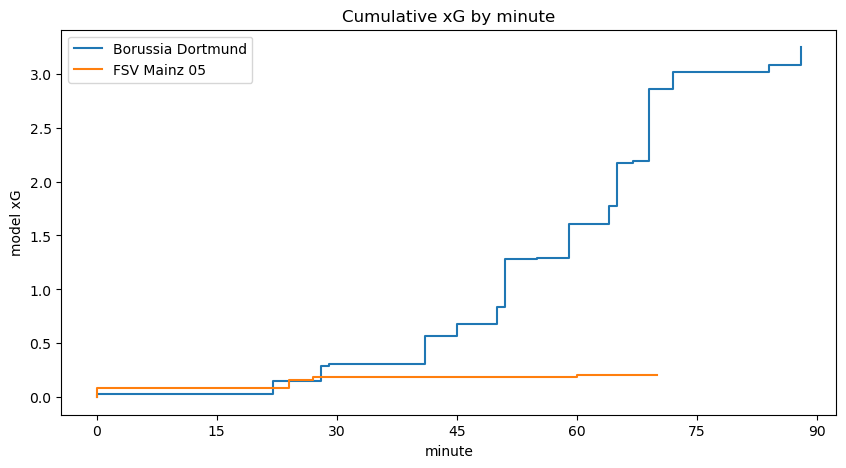

In [42]:
display_match_results_with_xG(Dortmund_games,match, display_shots=True, display_chart=True)